In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

from sklearn.model_selection import train_test_split
from bart_playground import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)

X = data.data
y = data.target

X = X.values.astype(float)
y = np.array(y).reshape(-1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [3]:
proposal_probs = {"multi_grow": 0.25, "multi_prune": 0.25, "multi_change": 0.4, "multi_swap": 0.1}
bart_mtmh = MultiBART(ndpost=1000, nskip=0, n_trees=100, proposal_probs=proposal_probs, multi_tries=10)
bart_mtmh.fit(X_train, y_train)
sigmas_mtmh = [trace.global_params['eps_sigma2'] for trace in bart_mtmh.sampler.trace]

Iterations: 100%|██████████| 1000/1000 [09:31<00:00,  1.75it/s]


In [4]:
proposal_probs = {"grow": 0.25, "prune": 0.25, "change": 0.4, "swap": 0.1}
bart_default = DefaultBART(ndpost=1000, nskip=0, n_trees=100, proposal_probs=proposal_probs)
bart_default.fit(X_train, y_train)
sigmas_default = [trace.global_params['eps_sigma2'] for trace in bart_default.sampler.trace]

Iterations: 100%|██████████| 1000/1000 [01:02<00:00, 16.06it/s]


In [5]:
# Analyze feature selection for each trace
feature_counts_per_trace_mtmh = []

for trace in bart_mtmh.trace:
    feature_counts = {}
    for tree in trace.trees:
        for var in tree.vars:
            if var >= 0:  # Only count valid split variables
                feature_counts[var] = feature_counts.get(var, 0) + 1
    feature_counts_per_trace_mtmh.append(feature_counts)

# Calculate split ratio for each variable in each trace
feature_ratios_per_trace_mtmh = []
for counts in feature_counts_per_trace_mtmh:
    total = sum(counts.values())
    if total == 0:
        ratios = {var: 0 for var in counts}
    else:
        ratios = {var: count / total for var, count in counts.items()}
    feature_ratios_per_trace_mtmh.append(ratios)

In [7]:
# Analyze feature selection for each trace
feature_counts_per_trace_default = []

for trace in bart_default.trace:
    feature_counts = {}
    for tree in trace.trees:
        for var in tree.vars:
            if var >= 0:  # Only count valid split variables
                feature_counts[var] = feature_counts.get(var, 0) + 1
    feature_counts_per_trace_default.append(feature_counts)

# Calculate split ratio for each variable in each trace
feature_ratios_per_trace_default = []
for counts in feature_counts_per_trace_default:
    total = sum(counts.values())
    if total == 0:
        ratios = {var: 0 for var in counts}
    else:
        ratios = {var: count / total for var, count in counts.items()}
    feature_ratios_per_trace_default.append(ratios)

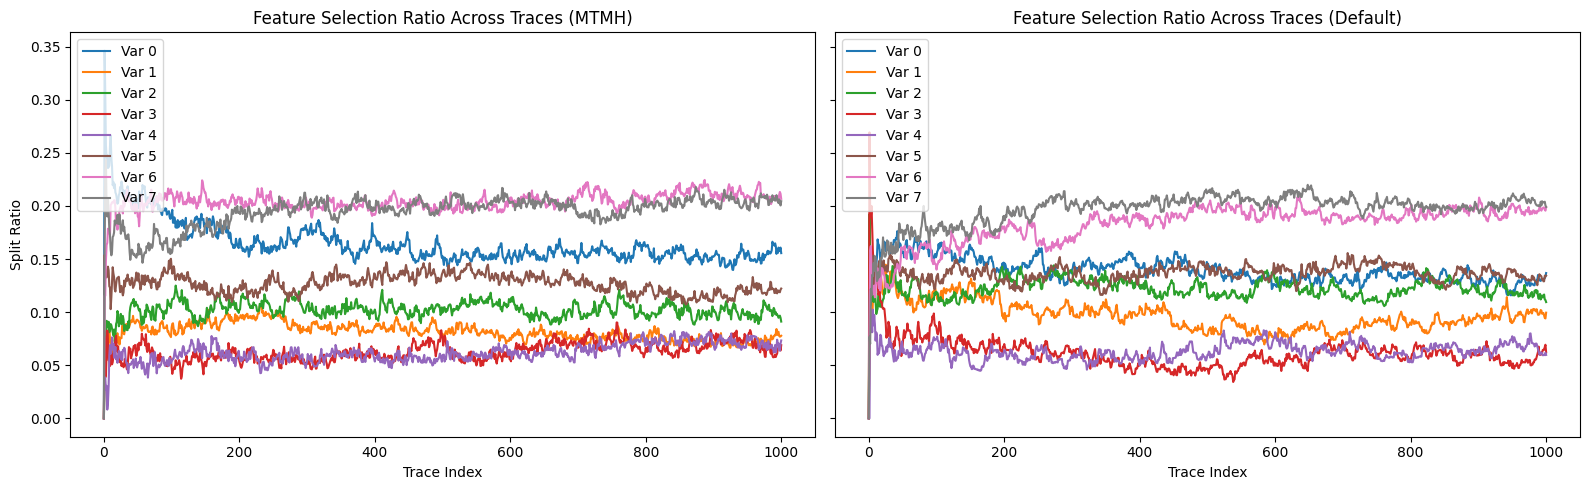

In [9]:
# Prepare data for MTMH
all_vars_mtmh = set()
for ratios in feature_ratios_per_trace_mtmh:
    all_vars_mtmh.update(ratios.keys())
all_vars_mtmh = sorted(all_vars_mtmh)

var_ratios_matrix_mtmh = []
for var in all_vars_mtmh:
    var_ratios = [ratios.get(var, 0) for ratios in feature_ratios_per_trace_mtmh]
    var_ratios_matrix_mtmh.append(var_ratios)

# Prepare data for Default
all_vars_default = set()
for ratios in feature_ratios_per_trace_default:
    all_vars_default.update(ratios.keys())
all_vars_default = sorted(all_vars_default)

var_ratios_matrix_default = []
for var in all_vars_default:
    var_ratios = [ratios.get(var, 0) for ratios in feature_ratios_per_trace_default]
    var_ratios_matrix_default.append(var_ratios)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# MTMH plot
for idx, var in enumerate(all_vars_mtmh):
    axes[0].plot(var_ratios_matrix_mtmh[idx], label=f'Var {var}')
axes[0].set_xlabel('Trace Index')
axes[0].set_ylabel('Split Ratio')
axes[0].set_title('Feature Selection Ratio Across Traces (MTMH)')
axes[0].legend()

# Default plot
for idx, var in enumerate(all_vars_default):
    axes[1].plot(var_ratios_matrix_default[idx], label=f'Var {var}')
axes[1].set_xlabel('Trace Index')
axes[1].set_title('Feature Selection Ratio Across Traces (Default)')
axes[1].legend()

plt.tight_layout()
plt.show()